# 02. Algebraic Diagnosis and Stability Analysis

**Objective:** Analyze the algebraic properties of the Design Matrix ($X$) to detect multicollinearity and assess numerical stability.

### Key Concepts
1.  **Matrix Rank:** Determines the number of linearly independent features. If $Rank(X) < Columns$, the system has infinite solutions (Perfect Multicollinearity).
2.  **Singular Value Decomposition (SVD):** Decomposes the matrix to reveal its underlying structure and redundant dimensions.
3.  **Condition Number ($\kappa$):** Quantifies the sensitivity of the system to input noise. A high $\kappa$ indicates an "ill-conditioned" problem where matrix inversion is unstable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Ensure we are in the correct directory
if not os.path.exists('Credit-Risk-Algebraic-ML'):
    !git clone https://github.com/adriangonz-afk/Credit-Risk-Algebraic-ML.git
    os.chdir('Credit-Risk-Algebraic-ML')

print("Environment configured.")

Cloning into 'Credit-Risk-Algebraic-ML'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 9), reused 16 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 62.76 KiB | 1.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Environment configured.


### 1. Data Loading and Bias Term Augmentation
We load the processed NumPy arrays. Additionally, we append a column of ones ($1$) to the matrix. In Linear Algebra, this allows the model to have an intercept (bias) term, enabling the hyperplane to be offset from the origin.

$$X_{augmented} = [ \mathbf{1} | X ]$$

In [2]:
# Load Matrices
X = np.load('data/processed/X_matrix.npy')
y = np.load('data/processed/y_vector.npy')

# Load Feature Names for reference
with open('data/processed/feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Augment X with a Bias column (Intercept)
# We add a column of 1s at index 0
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

print(f"Original X shape: {X.shape}")
print(f"Augmented X shape (with Bias): {X_bias.shape}")

Original X shape: (1000, 48)
Augmented X shape (with Bias): (1000, 49)


### 2. Matrix Rank Analysis
We calculate the Rank of the augmented matrix.

* **Full Rank:** All features contribute unique information.
* **Rank Deficient:** One or more features can be expressed as a linear combination of others. This causes the determinant of $X^T X$ to be zero, making standard inversion impossible.

In [3]:
# Compute Matrix Rank
rank = np.linalg.matrix_rank(X_bias)
num_features = X_bias.shape[1]

print(f"Matrix Rank: {rank}")
print(f"Total Features (Columns): {num_features}")

# Diagnosis
if rank < num_features:
    diff = num_features - rank
    print(f"DIAGNOSIS: The matrix is RANK DEFICIENT by {diff} dimension(s).")
    print("Result: Perfect Multicollinearity detected. Standard OLS will fail.")
else:
    print("DIAGNOSIS: The matrix is Full Rank.")

Matrix Rank: 49
Total Features (Columns): 49
DIAGNOSIS: The matrix is Full Rank.


### 3. Singular Value Decomposition (SVD)
We decompose the matrix such that $X = U \Sigma V^T$. The diagonal values of $\Sigma$ (Singular Values) represent the "strength" or variance captured by each dimension.

* **Steep decay:** Indicates that a few features capture most of the information.
* **Values near zero:** Indicate noise or redundancy.

Top 5 Singular Values: [1.36609613e+05 8.48460338e+02 3.12039389e+02 4.50547196e+01
 3.32605830e+01]
Bottom 5 Singular Values: [3.22837356 3.07016067 2.83466948 2.33579833 1.86039263]


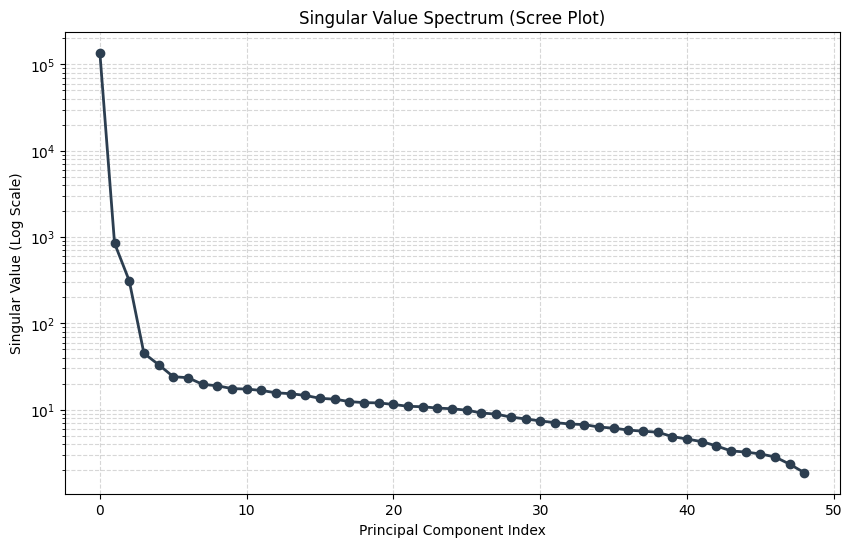

In [4]:
# Compute SVD
# U: Left singular vectors
# S: Singular values (Sigma) - 1D array
# Vt: Right singular vectors
U, S, Vt = np.linalg.svd(X_bias, full_matrices=False)

print(f"Top 5 Singular Values: {S[:5]}")
print(f"Bottom 5 Singular Values: {S[-5:]}")

# Visualization: Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(S, 'o-', linewidth=2, color='#2c3e50')
plt.title('Singular Value Spectrum (Scree Plot)')
plt.xlabel('Principal Component Index')
plt.ylabel('Singular Value (Log Scale)')
plt.yscale('log') # Log scale helps visualize the decay magnitude
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### 4. Condition Number ($\kappa$)
The Condition Number is the ratio of the largest to the smallest singular value:

$$\kappa(X) = \frac{\sigma_{max}}{\sigma_{min}}$$

* **Low $\kappa$ (e.g., < 100):** The system is well-conditioned. Stable.
* **High $\kappa$ (e.g., > 10,000):** The system is ill-conditioned. Small changes in input (noise) result in massive changes in the output (coefficients).

In [5]:
# Calculate Condition Number
sigma_max = S.max()
sigma_min = S.min()
condition_number = sigma_max / sigma_min

print(f"Max Singular Value: {sigma_max:.4f}")
print(f"Min Singular Value: {sigma_min:.4f}")
print("-" * 30)
print(f"Condition Number: {condition_number:.2e}")

# Interpretation logic
if condition_number > 1000:
    print("CONCLUSION: The matrix is ILL-CONDITIONED.")
    print("Recommendation: Use Regularization (Ridge/Lasso) or SVD-based solvers (Pseudoinverse).")
else:
    print("CONCLUSION: The matrix is Well-Conditioned.")

Max Singular Value: 136609.6125
Min Singular Value: 1.8604
------------------------------
Condition Number: 7.34e+04
CONCLUSION: The matrix is ILL-CONDITIONED.
Recommendation: Use Regularization (Ridge/Lasso) or SVD-based solvers (Pseudoinverse).
